In [26]:
# This line is needed to get nflows on the pod, at least until we update the container
!pip install --upgrade --quiet sbi

# This line is needed to get corner.py on the pod, at least until we update the container
!pip install corner

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Linear, Sigmoid, Sequential, ReLU
import torch.nn.functional as F
from torch import Tensor
import numpy as np
from tqdm import tqdm
import time
import corner
from torch.nn import DataParallel
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation, RandomPermutation

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
rc('text',usetex=True)
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=3, pad=3)
rc('xtick', labelsize=16)
rc('ytick.major', size=3, pad=3)
rc('ytick', labelsize=16)

In [27]:
# implementing a basic GRU model through pytorch
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  
        return out

In [28]:
# implementing the flow model
class ConditionalFlow(torch.nn.Module):
    def __init__(self, cond_channels, hidden_channels, out_channels, num_layers, dropout=0):
        # cond_channels specifies the conditionals (i.e. the outputs from the GNN as in context_features from the GNN)
        super(ConditionalFlow, self).__init__()
        # Flow

        base_dist = ConditionalDiagonalNormal(shape=[out_channels], 
                                      context_encoder=nn.Linear(cond_channels,2*out_channels))

        transforms = []
        for _ in range(num_layers):
            transforms.append(ReversePermutation(features=out_channels))
            transforms.append(MaskedAffineAutoregressiveTransform(features=out_channels, 
                                                          hidden_features=hidden_channels, 
                                                          context_features=cond_channels))
        transform = CompositeTransform(transforms)

        self.flow = Flow(transform, base_dist)

    def forward(self):
        # x = self.flow
        return self.flow

In [29]:
# generating sine wave data
def generate_sine_wave_data(seq_length, num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        freq = np.random.uniform(0.1, 0.5)
        phase = np.random.uniform(-np.pi, np.pi)
        x = np.linspace(0, 2 * np.pi, seq_length)
        y_sine = np.sin(freq * x + phase)
        noise = 0.1 * np.random.randn(seq_length)
        y_noisy = y_sine + noise
        X.append(y_noisy)
        y.append([freq, phase])
    X = np.array(X).reshape(-1, seq_length, 1)
    y = np.array(y)
    return X, y

# Parameters
seq_length = 50
num_samples = 1000

# Generate data
X, y = generate_sine_wave_data(seq_length, num_samples)
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
# GRU model inputs
input_size = 1  # Sine wave input
hidden_size = 64 # number of hidden neurons
num_layers = 2 # number of layers in GRU model
output_size = 10  # number of summary features

# nflows imput
context_features = 10 # number based on GRU model output
output_features = 2 # number of final output features (2 in our case)
flow_hidden_features = 16 # nflows hidden_features
num_layers_flow = 8 # number of layers in nflows

# moving the model and nflow to cuda device
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)
flow = ConditionalFlow(cond_channels=context_features, hidden_channels=flow_hidden_features,
                       out_channels=output_features, num_layers=num_layers_flow).to(device)

# implement multi-GPUs
if torch.cuda.device_count() > 1:
    gru_model = DataParallel(gru_model)
    flow = DataParallel(flow)

In [31]:
optimizer = optim.Adam(list(gru_model.parameters()) + list(flow.parameters()), lr=0.001)

def criterion(data, context, flow):
    if torch.cuda.device_count() > 1:
        this_batch = len(data)
        loss = -flow.module.flow.log_prob(inputs=data, context=context.view(this_batch, context_features)).mean()
    else:
        this_batch = len(data)
        loss = -flow.flow.log_prob(inputs=data, context=context.view(this_batch, context_features)).mean()
    return loss

def train(model, flow, optimizer, loader):
    total_loss = 0
    model.train()
    flow.train()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(target, out, flow)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def test(model, flow, loader):
    total_loss = 0
    model.eval()
    flow.eval()
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        out = model(data)
        loss = criterion(target, out, flow)
        total_loss += loss.item() * data.size(0)
    return total_loss / len(loader.dataset)

In [32]:
loss_hist = []

start = time.process_time()
for epoch in tqdm(range(1, 100)):
    train_loss = train(gru_model, flow, optimizer, train_loader)
    test_loss = test(gru_model, flow, train_loader)
    loss_hist.append([train_loss, test_loss])
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

loss_hist = np.array(loss_hist)
print('Time elapsed: ', time.process_time() - start)

  1%|▉                                                                                      | 1/99 [00:00<00:56,  1.75it/s]

Epoch: 001, Train Loss: 4.7720, Test Loss: 1.6364


  2%|█▊                                                                                     | 2/99 [00:01<00:54,  1.80it/s]

Epoch: 002, Train Loss: 1.3569, Test Loss: 1.1680


  3%|██▋                                                                                    | 3/99 [00:01<00:53,  1.81it/s]

Epoch: 003, Train Loss: 1.0307, Test Loss: 0.8034


  4%|███▌                                                                                   | 4/99 [00:02<00:52,  1.81it/s]

Epoch: 004, Train Loss: 0.4483, Test Loss: 0.5221


  5%|████▍                                                                                  | 5/99 [00:02<00:51,  1.81it/s]

Epoch: 005, Train Loss: 0.2256, Test Loss: -0.0594


  6%|█████▎                                                                                 | 6/99 [00:03<00:51,  1.82it/s]

Epoch: 006, Train Loss: -0.2439, Test Loss: -0.1524


  7%|██████▏                                                                                | 7/99 [00:03<00:50,  1.82it/s]

Epoch: 007, Train Loss: -0.6067, Test Loss: -0.6705


  8%|███████                                                                                | 8/99 [00:04<00:49,  1.83it/s]

Epoch: 008, Train Loss: -0.8230, Test Loss: -1.0668


  9%|███████▉                                                                               | 9/99 [00:04<00:48,  1.84it/s]

Epoch: 009, Train Loss: -1.0300, Test Loss: -1.1298


 10%|████████▋                                                                             | 10/99 [00:05<00:48,  1.84it/s]

Epoch: 010, Train Loss: -0.9509, Test Loss: -1.4558


 11%|█████████▌                                                                            | 11/99 [00:06<00:47,  1.85it/s]

Epoch: 011, Train Loss: -1.1584, Test Loss: -1.1247


 12%|██████████▍                                                                           | 12/99 [00:06<00:47,  1.84it/s]

Epoch: 012, Train Loss: -1.4267, Test Loss: -1.8281


 13%|███████████▎                                                                          | 13/99 [00:07<00:46,  1.85it/s]

Epoch: 013, Train Loss: -1.6438, Test Loss: -1.6613


 14%|████████████▏                                                                         | 14/99 [00:07<00:46,  1.84it/s]

Epoch: 014, Train Loss: -1.7272, Test Loss: -1.8201


 15%|█████████████                                                                         | 15/99 [00:08<00:45,  1.84it/s]

Epoch: 015, Train Loss: -1.9470, Test Loss: -2.0668


 16%|█████████████▉                                                                        | 16/99 [00:08<00:46,  1.78it/s]

Epoch: 016, Train Loss: -2.1644, Test Loss: -1.4317


 17%|██████████████▊                                                                       | 17/99 [00:09<00:47,  1.74it/s]

Epoch: 017, Train Loss: -1.4010, Test Loss: -1.8776


 18%|███████████████▋                                                                      | 18/99 [00:10<00:47,  1.71it/s]

Epoch: 018, Train Loss: -2.1730, Test Loss: -2.0301


 19%|████████████████▌                                                                     | 19/99 [00:10<00:46,  1.73it/s]

Epoch: 019, Train Loss: -2.1262, Test Loss: -2.2121


 20%|█████████████████▎                                                                    | 20/99 [00:11<00:45,  1.75it/s]

Epoch: 020, Train Loss: -2.3308, Test Loss: -2.5329


 21%|██████████████████▏                                                                   | 21/99 [00:11<00:44,  1.77it/s]

Epoch: 021, Train Loss: -2.4702, Test Loss: -1.1115


 22%|███████████████████                                                                   | 22/99 [00:12<00:43,  1.78it/s]

Epoch: 022, Train Loss: -2.0544, Test Loss: -2.6800


 23%|███████████████████▉                                                                  | 23/99 [00:12<00:42,  1.79it/s]

Epoch: 023, Train Loss: -2.6719, Test Loss: -2.8082


 24%|████████████████████▊                                                                 | 24/99 [00:13<00:41,  1.80it/s]

Epoch: 024, Train Loss: -2.6770, Test Loss: -2.3621


 25%|█████████████████████▋                                                                | 25/99 [00:13<00:40,  1.82it/s]

Epoch: 025, Train Loss: -2.7276, Test Loss: -3.0841


 26%|██████████████████████▌                                                               | 26/99 [00:14<00:40,  1.82it/s]

Epoch: 026, Train Loss: -2.6522, Test Loss: -2.1725


 27%|███████████████████████▍                                                              | 27/99 [00:14<00:39,  1.83it/s]

Epoch: 027, Train Loss: -2.8545, Test Loss: -3.1634


 28%|████████████████████████▎                                                             | 28/99 [00:15<00:38,  1.83it/s]

Epoch: 028, Train Loss: -2.6885, Test Loss: -2.1646


 29%|█████████████████████████▏                                                            | 29/99 [00:16<00:38,  1.83it/s]

Epoch: 029, Train Loss: -2.6754, Test Loss: -3.1458


 30%|██████████████████████████                                                            | 30/99 [00:16<00:37,  1.84it/s]

Epoch: 030, Train Loss: -3.2083, Test Loss: -3.5995


 31%|██████████████████████████▉                                                           | 31/99 [00:17<00:37,  1.83it/s]

Epoch: 031, Train Loss: -3.2860, Test Loss: -3.5837


 32%|███████████████████████████▊                                                          | 32/99 [00:17<00:36,  1.83it/s]

Epoch: 032, Train Loss: -3.3211, Test Loss: -3.0229


 33%|████████████████████████████▋                                                         | 33/99 [00:18<00:36,  1.82it/s]

Epoch: 033, Train Loss: -3.4300, Test Loss: -3.3494


 34%|█████████████████████████████▌                                                        | 34/99 [00:18<00:36,  1.80it/s]

Epoch: 034, Train Loss: -3.2258, Test Loss: -3.4062


 35%|██████████████████████████████▍                                                       | 35/99 [00:19<00:35,  1.81it/s]

Epoch: 035, Train Loss: -3.4539, Test Loss: -3.6630


 36%|███████████████████████████████▎                                                      | 36/99 [00:19<00:34,  1.82it/s]

Epoch: 036, Train Loss: -3.5649, Test Loss: -2.6813


 37%|████████████████████████████████▏                                                     | 37/99 [00:20<00:34,  1.82it/s]

Epoch: 037, Train Loss: -3.4103, Test Loss: -3.7349


 38%|█████████████████████████████████                                                     | 38/99 [00:20<00:33,  1.82it/s]

Epoch: 038, Train Loss: -3.1399, Test Loss: -3.4055


 39%|█████████████████████████████████▉                                                    | 39/99 [00:21<00:33,  1.82it/s]

Epoch: 039, Train Loss: -3.4414, Test Loss: -3.1552


 40%|██████████████████████████████████▋                                                   | 40/99 [00:22<00:32,  1.82it/s]

Epoch: 040, Train Loss: -3.5219, Test Loss: -3.3832


 41%|███████████████████████████████████▌                                                  | 41/99 [00:22<00:31,  1.82it/s]

Epoch: 041, Train Loss: -3.2822, Test Loss: -3.4683


 42%|████████████████████████████████████▍                                                 | 42/99 [00:23<00:31,  1.82it/s]

Epoch: 042, Train Loss: -3.4687, Test Loss: -2.9165


 43%|█████████████████████████████████████▎                                                | 43/99 [00:23<00:31,  1.76it/s]

Epoch: 043, Train Loss: -3.5875, Test Loss: -3.9153


 44%|██████████████████████████████████████▏                                               | 44/99 [00:24<00:31,  1.73it/s]

Epoch: 044, Train Loss: -3.8141, Test Loss: -3.7268


 45%|███████████████████████████████████████                                               | 45/99 [00:25<00:31,  1.70it/s]

Epoch: 045, Train Loss: -3.6658, Test Loss: -3.9575


 46%|███████████████████████████████████████▉                                              | 46/99 [00:25<00:30,  1.72it/s]

Epoch: 046, Train Loss: -3.6424, Test Loss: -3.0041


 47%|████████████████████████████████████████▊                                             | 47/99 [00:26<00:29,  1.75it/s]

Epoch: 047, Train Loss: -3.6106, Test Loss: -3.7327


 48%|█████████████████████████████████████████▋                                            | 48/99 [00:26<00:28,  1.77it/s]

Epoch: 048, Train Loss: -3.7020, Test Loss: -3.4455


 49%|██████████████████████████████████████████▌                                           | 49/99 [00:27<00:27,  1.79it/s]

Epoch: 049, Train Loss: -3.5961, Test Loss: -3.8736


 51%|███████████████████████████████████████████▍                                          | 50/99 [00:27<00:27,  1.81it/s]

Epoch: 050, Train Loss: -3.7278, Test Loss: -3.5270


 52%|████████████████████████████████████████████▎                                         | 51/99 [00:28<00:26,  1.81it/s]

Epoch: 051, Train Loss: -3.1235, Test Loss: -3.2938


 53%|█████████████████████████████████████████████▏                                        | 52/99 [00:28<00:25,  1.82it/s]

Epoch: 052, Train Loss: -3.6555, Test Loss: -3.4063


 54%|██████████████████████████████████████████████                                        | 53/99 [00:29<00:25,  1.83it/s]

Epoch: 053, Train Loss: -3.8743, Test Loss: -4.0671


 55%|██████████████████████████████████████████████▉                                       | 54/99 [00:29<00:24,  1.83it/s]

Epoch: 054, Train Loss: -3.6234, Test Loss: -3.8734


 56%|███████████████████████████████████████████████▊                                      | 55/99 [00:30<00:24,  1.83it/s]

Epoch: 055, Train Loss: -3.8039, Test Loss: -3.6787


 57%|████████████████████████████████████████████████▋                                     | 56/99 [00:31<00:23,  1.83it/s]

Epoch: 056, Train Loss: -3.6648, Test Loss: -3.8546


 58%|█████████████████████████████████████████████████▌                                    | 57/99 [00:31<00:22,  1.83it/s]

Epoch: 057, Train Loss: -3.9117, Test Loss: -3.7428


 59%|██████████████████████████████████████████████████▍                                   | 58/99 [00:32<00:22,  1.83it/s]

Epoch: 058, Train Loss: -3.9420, Test Loss: -3.4234


 60%|███████████████████████████████████████████████████▎                                  | 59/99 [00:32<00:21,  1.83it/s]

Epoch: 059, Train Loss: -3.6914, Test Loss: -3.8803


 61%|████████████████████████████████████████████████████                                  | 60/99 [00:33<00:21,  1.83it/s]

Epoch: 060, Train Loss: -3.6472, Test Loss: -3.6662


 62%|████████████████████████████████████████████████████▉                                 | 61/99 [00:33<00:20,  1.84it/s]

Epoch: 061, Train Loss: -3.5434, Test Loss: -3.8763


 63%|█████████████████████████████████████████████████████▊                                | 62/99 [00:34<00:20,  1.84it/s]

Epoch: 062, Train Loss: -3.9482, Test Loss: -3.9455


 64%|██████████████████████████████████████████████████████▋                               | 63/99 [00:34<00:19,  1.83it/s]

Epoch: 063, Train Loss: -3.8107, Test Loss: -4.1780


 65%|███████████████████████████████████████████████████████▌                              | 64/99 [00:35<00:19,  1.83it/s]

Epoch: 064, Train Loss: -4.0180, Test Loss: -3.8979


 66%|████████████████████████████████████████████████████████▍                             | 65/99 [00:35<00:18,  1.83it/s]

Epoch: 065, Train Loss: -3.8857, Test Loss: -3.8606


 67%|█████████████████████████████████████████████████████████▎                            | 66/99 [00:36<00:18,  1.81it/s]

Epoch: 066, Train Loss: -3.8048, Test Loss: -3.8330


 68%|██████████████████████████████████████████████████████████▏                           | 67/99 [00:37<00:18,  1.77it/s]

Epoch: 067, Train Loss: -3.9848, Test Loss: -2.7935


 69%|███████████████████████████████████████████████████████████                           | 68/99 [00:37<00:17,  1.78it/s]

Epoch: 068, Train Loss: -3.7999, Test Loss: -4.2382


 70%|███████████████████████████████████████████████████████████▉                          | 69/99 [00:38<00:16,  1.80it/s]

Epoch: 069, Train Loss: -3.9055, Test Loss: -3.4353


 71%|████████████████████████████████████████████████████████████▊                         | 70/99 [00:38<00:15,  1.82it/s]

Epoch: 070, Train Loss: -3.9063, Test Loss: -4.0463


 72%|█████████████████████████████████████████████████████████████▋                        | 71/99 [00:39<00:15,  1.82it/s]

Epoch: 071, Train Loss: -4.0970, Test Loss: -4.1581


 73%|██████████████████████████████████████████████████████████████▌                       | 72/99 [00:39<00:14,  1.84it/s]

Epoch: 072, Train Loss: -3.4645, Test Loss: -3.9686


 74%|███████████████████████████████████████████████████████████████▍                      | 73/99 [00:40<00:14,  1.84it/s]

Epoch: 073, Train Loss: -3.9608, Test Loss: -3.3118


 75%|████████████████████████████████████████████████████████████████▎                     | 74/99 [00:40<00:13,  1.83it/s]

Epoch: 074, Train Loss: -3.8307, Test Loss: -4.1329


 76%|█████████████████████████████████████████████████████████████████▏                    | 75/99 [00:41<00:13,  1.83it/s]

Epoch: 075, Train Loss: -4.1287, Test Loss: -3.6445


 77%|██████████████████████████████████████████████████████████████████                    | 76/99 [00:42<00:12,  1.83it/s]

Epoch: 076, Train Loss: -4.0529, Test Loss: -3.5863


 78%|██████████████████████████████████████████████████████████████████▉                   | 77/99 [00:42<00:12,  1.83it/s]

Epoch: 077, Train Loss: -3.9487, Test Loss: -3.4875


 79%|███████████████████████████████████████████████████████████████████▊                  | 78/99 [00:43<00:11,  1.83it/s]

Epoch: 078, Train Loss: -4.1008, Test Loss: -3.1398


 80%|████████████████████████████████████████████████████████████████████▋                 | 79/99 [00:43<00:10,  1.83it/s]

Epoch: 079, Train Loss: -3.4289, Test Loss: -3.7897


 81%|█████████████████████████████████████████████████████████████████████▍                | 80/99 [00:44<00:10,  1.83it/s]

Epoch: 080, Train Loss: -4.0975, Test Loss: -3.9823


 82%|██████████████████████████████████████████████████████████████████████▎               | 81/99 [00:44<00:09,  1.83it/s]

Epoch: 081, Train Loss: -4.1158, Test Loss: -4.2785


 83%|███████████████████████████████████████████████████████████████████████▏              | 82/99 [00:45<00:09,  1.83it/s]

Epoch: 082, Train Loss: -4.0593, Test Loss: -4.2882


 84%|████████████████████████████████████████████████████████████████████████              | 83/99 [00:45<00:08,  1.82it/s]

Epoch: 083, Train Loss: -4.2229, Test Loss: -3.5995


 85%|████████████████████████████████████████████████████████████████████████▉             | 84/99 [00:46<00:08,  1.82it/s]

Epoch: 084, Train Loss: -3.6784, Test Loss: -3.9099


 86%|█████████████████████████████████████████████████████████████████████████▊            | 85/99 [00:46<00:07,  1.83it/s]

Epoch: 085, Train Loss: -4.2248, Test Loss: -3.7893


 87%|██████████████████████████████████████████████████████████████████████████▋           | 86/99 [00:47<00:07,  1.81it/s]

Epoch: 086, Train Loss: -4.1141, Test Loss: -4.0821


 88%|███████████████████████████████████████████████████████████████████████████▌          | 87/99 [00:48<00:06,  1.76it/s]

Epoch: 087, Train Loss: -3.9298, Test Loss: -4.2121


 89%|████████████████████████████████████████████████████████████████████████████▍         | 88/99 [00:48<00:06,  1.73it/s]

Epoch: 088, Train Loss: -3.7765, Test Loss: -4.1148


 90%|█████████████████████████████████████████████████████████████████████████████▎        | 89/99 [00:49<00:05,  1.70it/s]

Epoch: 089, Train Loss: -4.0969, Test Loss: -3.9897


 91%|██████████████████████████████████████████████████████████████████████████████▏       | 90/99 [00:49<00:05,  1.68it/s]

Epoch: 090, Train Loss: -4.0899, Test Loss: -4.0691


 92%|███████████████████████████████████████████████████████████████████████████████       | 91/99 [00:50<00:04,  1.67it/s]

Epoch: 091, Train Loss: -4.1936, Test Loss: -3.8447


 93%|███████████████████████████████████████████████████████████████████████████████▉      | 92/99 [00:51<00:04,  1.67it/s]

Epoch: 092, Train Loss: -3.8326, Test Loss: -4.0473


 94%|████████████████████████████████████████████████████████████████████████████████▊     | 93/99 [00:51<00:03,  1.67it/s]

Epoch: 093, Train Loss: -4.0401, Test Loss: -4.1635


 95%|█████████████████████████████████████████████████████████████████████████████████▋    | 94/99 [00:52<00:03,  1.67it/s]

Epoch: 094, Train Loss: -4.0266, Test Loss: -3.9551


 96%|██████████████████████████████████████████████████████████████████████████████████▌   | 95/99 [00:52<00:02,  1.67it/s]

Epoch: 095, Train Loss: -4.1026, Test Loss: -4.0019


 97%|███████████████████████████████████████████████████████████████████████████████████▍  | 96/99 [00:53<00:01,  1.66it/s]

Epoch: 096, Train Loss: -4.2370, Test Loss: -4.4327


 98%|████████████████████████████████████████████████████████████████████████████████████▎ | 97/99 [00:54<00:01,  1.67it/s]

Epoch: 097, Train Loss: -4.3165, Test Loss: -4.1695


 99%|█████████████████████████████████████████████████████████████████████████████████████▏| 98/99 [00:54<00:00,  1.68it/s]

Epoch: 098, Train Loss: -4.2141, Test Loss: -3.9896


100%|██████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:55<00:00,  1.79it/s]

Epoch: 099, Train Loss: -3.8437, Test Loss: -3.9143
Time elapsed:  55.365863528999995


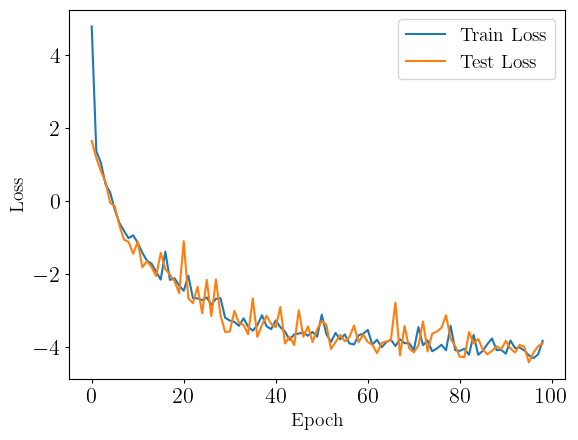

In [33]:
plt.plot(loss_hist[:, 0], label='Train Loss')
plt.plot(loss_hist[:, 1], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

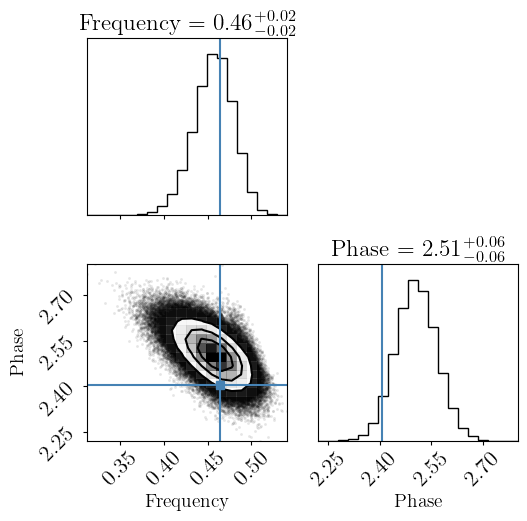

In [54]:
# we are using the same train_loader here but we can fix this when we implement our data
test_data_iter = iter(train_loader)  
test_data, test_target = next(test_data_iter)  # get the first batch

# move the data to the appropriate device
test_data = test_data.to(device)
test_target = test_target.to(device)

# ensure the model is in evaluation mode
gru_model.eval()

# perform the forward pass with no gradient calculation
with torch.no_grad():
    if torch.cuda.device_count() > 1:
        test_context = gru_model.module(test_data)  # if using DataParallel
    else:
        test_context = gru_model(test_data)

# use only the first sample in the batch for simplicity
test_context_single = test_context[0].unsqueeze(0)
test_target_single = test_target[0].unsqueeze(0)

# generate samples from the flow model based on the context
num_samples = 500
with torch.no_grad():
    if torch.cuda.device_count() > 1:
        samples = flow.module.flow.sample(num_samples, context=test_context_single.expand(num_samples, -1))
    else:
        samples = flow.flow.sample(num_samples, context=test_context_single.expand(num_samples, -1))

# convert samples and true values to numpy arrays
samples_np = samples.cpu().numpy()
true_values = test_target_single.cpu().numpy().flatten()

# labels for the corner plot
feature_labels = ["Frequency", "Phase"]

# create and display the corner plot
figure = corner.corner(samples_np, labels=feature_labels, truths=true_values, show_titles=True, title_fmt='.2f')
plt.tight_layout()
plt.show()

In [55]:
def get_preds(model, flow, dataset):
    # An empty list to store samples from all streams
    mean, std, true = [], [], []
    y_mean, y_sig, y_true = [], [], []

    # Generate samples for each graph in the test dataset
    for data in dataset:
        data0, target = (data[0].unsqueeze(0)).to(device), data[1].to(device)
        
        # Extract context from the data0
        if torch.cuda.device_count() > 1:
            data_to_context = model.module(data0)
        elif torch.cuda.device_count() == 1 or torch.cuda.device_count() < 1:
            data_to_context = model(data0)
        
        # Generate samples from the flow model on the provided context
        num_samples = 500 
        with torch.no_grad():
            if torch.cuda.device_count() > 1:
                samples = flow.module.flow.sample(num_samples, context=data_to_context.expand(num_samples, -1))
            elif torch.cuda.device_count() == 1 or torch.cuda.device_count() < 1:
                samples = flow.flow.sample(num_samples, context=data_to_context.expand(num_samples, -1))
    
        samples_np = samples.cpu().numpy()
    
        mean_samples = np.mean(np.mean(samples_np, axis=0), axis=0)
        std_samples = np.mean(np.std(samples_np, axis=0), axis=0)
    
        mean.append(mean_samples.tolist())
        std.append(std_samples.tolist())
        true.append(target.cpu().numpy())

    y_mean = [[item[0] for item in mean], [item[1] for item in mean]]
    y_sig = [[item[0] for item in std], [item[1] for item in std]]
    y_true = [[item[0] for item in true], [item[1] for item in true]]

    return y_mean, y_sig, y_true

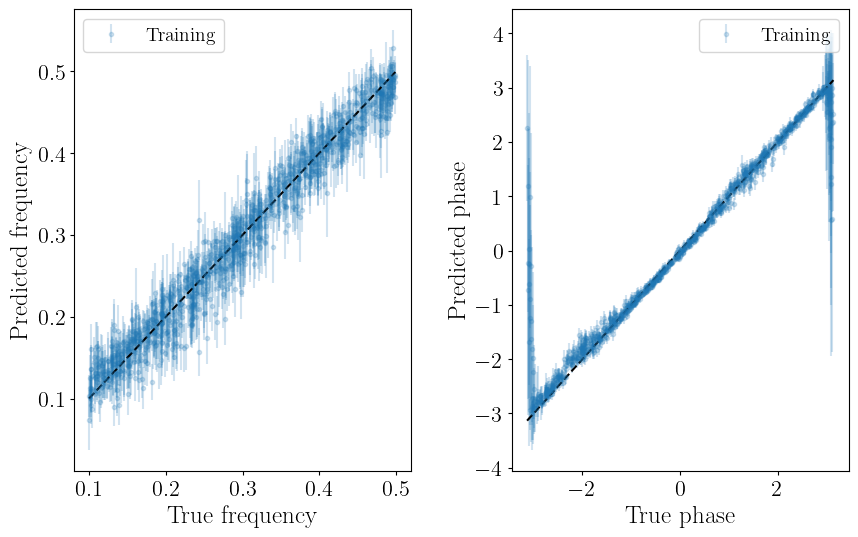

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
plt.subplots_adjust(wspace=0.3)

y_mean, y_sig, y_true = get_preds(gru_model,flow,dataset)
ax[0].errorbar(y_true[0],y_mean[0],y_sig[0],alpha=0.2,fmt='.',label='Training')
ax[1].errorbar(y_true[1],y_mean[1],y_sig[1],alpha=0.2,fmt='.',label='Training')

yy = np.linspace(min(y_true[0]),max(y_true[0]))
ax[0].plot(yy,yy,color='k',linestyle='--')

yy = np.linspace(min(y_true[1]),max(y_true[1]))
ax[1].plot(yy,yy,color='k',linestyle='--')

ax[0].set_xlabel(r'True frequency',fontsize=18)
ax[0].set_ylabel(r'Predicted frequency',fontsize=18)

ax[1].set_xlabel(r'True phase',fontsize=18)
ax[1].set_ylabel(r'Predicted phase',fontsize=18)

ax[0].legend(loc='best')
ax[1].legend(loc='best')